In [ ]:
%autosave 0
import torch
import torch.nn as nn
!pip install transformers
import transformers
from transformers import BertModel, BertForMaskedLM
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from string import punctuation
torch.manual_seed(1)
import random; random.seed(1)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import metrics
torch.random.manual_seed(1)
import matplotlib.pyplot as mat

Autosave disabled
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 34.3 MB/s 
     |████████████████████████████████| 182 kB 66.9 MB/s 
     |████████████████████████████████| 7.6 MB 62.9 MB/s 


In [ ]:
torch.cuda.is_available()

True

In [ ]:
if torch.cuda.is_available():  
  device = torch.device("cuda")
else:  
  device = torch.device("cpu")

In [ ]:
#Corpus
file = open('/content/Sentences_75Agree.txt',encoding="ISO-8859-1")
file=file.readlines()
corpus=file

In [ ]:
len(corpus)

3453

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#Tokenize and lower casing
def preprocess_sentence(sentence):
  return tokenizer.tokenize(sentence)

sentences=[]
sentences1 = [preprocess_sentence(sent) for sent in corpus]
for i in range(len(sentences1)):
    sentences.append(sentences1[i][0:len(sentences1[i])-2])

In [ ]:
lengths=[len(i) for i in sentences]
np.max(lengths)

148

In [ ]:
#Labelling data with a response
y1=[]; y=[]
for i in range(len(sentences1)):
    y1.append(sentences1[i][len(sentences1[i])-1])

for i in y1:
    if i =='positive':
        i=[1,0,0]
    elif i=='neutral':
        i=[0,1,0]
    else: i=[0,0,1]
    y.append(i)

In [ ]:
#Converting tokens to ids. Note that [CLS] [SEP] are included into the max length.
x=[tokenizer.encode_plus(sent, max_length=126+2,add_special_tokens=True,pad_to_max_length=True,
                         return_attention_mask=True,return_token_type_ids=False, truncation=True) for sent in sentences]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Note that attention_mask returns 1 for tokens of interest and 0 for padding

In [ ]:
x_input = [i['input_ids'] for i in x]
x_mask = [i['attention_mask'] for i in x]

In [ ]:
# Train/test/validation splitting
train_x_input, test_x_input, train_x_mask, test_x_mask, train_y, test_y = train_test_split(x_input,
                                                                                           x_mask,
                                                                                           y,
                                                                                           test_size=0.2,
                                                                                           random_state=42)
#Further split for validation
val_x_input, test_x_input, val_x_mask, test_x_mask, val_y, test_y = train_test_split(test_x_input,
                                                                                           test_x_mask,
                                                                                           test_y,
                                                                                           test_size=0.5,
                                                                                           random_state=42)

# Neural network architecture and optimizer

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased',return_dict=False)
        self.l1 = nn.Linear(self.bert.config.hidden_size,3)
        self.prob=nn.Softmax(dim=1)
    
    # B = batch_size, L = sentence_length, D = embed_dim, H = hidden_size
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask) #Inputs () outputs () 
        out=self.l1(pooled_output) #Inputs (768) outputs (3)
        out=self.prob(out)
        return out

In [ ]:
# Initialize a model
model = NeuralNet()
model = model.to(device)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Define an optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Define a loss function, which computes to cross entropy loss
def loss_function(batch_outputs, batch_labels):   
    # Calculate the loss for the whole batch
    celoss = nn.CrossEntropyLoss()
    loss = celoss(batch_outputs, batch_labels.float())

    # Rescale the loss. Already accounted for in CEloss
    #loss = loss / batch_size

    return loss

In [ ]:
# Function that will be called in every epoch
def train_epoch(loss_function, optimizer, model, loader):
  
  model.train()
  # Keep track of the total loss for the batch
  total_loss_train = 0
  total_loss_test = 0
  for batch_inputs, batch_mask, batch_labels in loader:
    # Clear the gradients
    optimizer.zero_grad()
    # Run a forward pass
    outputs = model.forward(batch_inputs, batch_mask)
    # Compute the batch loss
    loss = loss_function(outputs, batch_labels)
    # Calculate the gradients
    loss.backward()
    #Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1)
    # Update the parameteres
    optimizer.step()
    total_loss_train += loss.item()/len(loader) #one full epoch loss

  model.eval() 
  global pred, true
  pred=[]; true=[] 
  for test_instance, test_mask, labels in test_loader:
    # Run a forward pass
    outputs = model.forward(test_instance, test_mask)
    # Compute the batch loss
    loss = loss_function(outputs, labels)
    total_loss_test += loss.item()/len(test_loader)
    #Compute accuracy
    pred_temp = [0,0,0]
    pred_temp[np.argmax((outputs.detach().tolist())[0])]=1
    pred.append(pred_temp)
    true_temp = labels.tolist()[0]
    true.append(true_temp)
    accuracy = metrics.accuracy_score(true,pred)*100
    f1=metrics.f1_score(true,pred,average="macro")*100

  return total_loss_train, total_loss_test, accuracy, f1


# Function containing our main training loop
def train(loss_function, optimizer, model, loader, num_epochs):
  global history
  history=[]
  # Iterate through each epoch and call our train_epoch function
  for epoch in range(num_epochs):
    epoch_loss = train_epoch(loss_function, optimizer, model, loader)
    if epoch % 1 == 0: print('Epoch:',epoch+1,'Losses:', epoch_loss[0:2],'Test Accuracy:',epoch_loss[2], 'F1:', epoch_loss[3])
    history.append(epoch_loss)
    
  history=np.array(history)
  mat.figure(figsize=(10,5))
  mat.plot(history[:,0], 'b-', label='Training Loss')
  mat.plot(history[:,1], 'r-', label='Test Loss')
  mat.title("Training/Test Loss")
  mat.xlabel("Epochs")
  mat.ylabel("Loss")
  mat.legend(loc="upper right") 
  mat.show()

  mat.figure(figsize=(10,5))
  mat.plot(history[:,2], 'o-', label='Test Accuracy')
  mat.plot(history[:,3], 'p-', label='F1 Score')
  mat.title("Training/Validation Loss")
  mat.xlabel("Epochs")
  mat.ylabel("Loss")
  mat.legend(loc="upper right") 
  mat.show()
        

# This part is for the tuning of hyperparameters with CV

In [ ]:
random.seed(1)
torch.random.manual_seed(1)
#Hyperparameters
#Don't forget to change sentence length as an input also. Currently using 80
batch_size = 32
num_epochs = 20
learning_rate=0.00001

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labe

Epoch: 1 Losses: (0.9126319122868913, 0.7835435383756397) Test Accuracy: 79.43661971830987 F1: 53.08801054808067


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 2 Losses: (0.7293835067471793, 0.6637089111435571) Test Accuracy: 90.14084507042254 F1: 88.67784992784993


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 3 Losses: (0.6220785420994427, 0.6363904905990815) Test Accuracy: 91.83098591549296 F1: 90.49248952804173


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 4 Losses: (0.5923080971074658, 0.633554701402154) Test Accuracy: 92.11267605633803 F1: 89.71064121746083


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 5 Losses: (0.5852111231449041, 0.6163742317280292) Test Accuracy: 94.36619718309859 F1: 92.82522787537744


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 6 Losses: (0.57720053542492, 0.6175772515820791) Test Accuracy: 93.2394366197183 F1: 91.00118835412955


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 7 Losses: (0.5734604728776357, 0.6158409706303771) Test Accuracy: 92.95774647887323 F1: 90.38207209337537


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 8 Losses: (0.5724129330280215, 0.6325778386962246) Test Accuracy: 91.83098591549296 F1: 90.4321458009467


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 9 Losses: (0.5720273762248285, 0.608025584086566) Test Accuracy: 94.64788732394366 F1: 93.05219804816906


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 10 Losses: (0.5680451372335125, 0.6077392289336302) Test Accuracy: 94.36619718309859 F1: 92.41332905754786


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 11 Losses: (0.5673035196093625, 0.6063915277870603) Test Accuracy: 94.64788732394366 F1: 92.66534546256625


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 12 Losses: (0.5663128779378048, 0.6165715266281449) Test Accuracy: 93.2394366197183 F1: 91.53583321236435


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 13 Losses: (0.5652474809524627, 0.6110189629272672) Test Accuracy: 94.08450704225352 F1: 92.18542308609216


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 14 Losses: (0.5644978645235995, 0.6265319520319006) Test Accuracy: 91.83098591549296 F1: 89.74638081467498


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 15 Losses: (0.5639723359152328, 0.6105880082493096) Test Accuracy: 94.08450704225352 F1: 91.7312129012779


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 16 Losses: (0.5636645326780717, 0.6146194689710373) Test Accuracy: 93.52112676056338 F1: 91.57174175652095


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 17 Losses: (0.5626171092654384, 0.6099684421445288) Test Accuracy: 93.80281690140845 F1: 92.15277980462294


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 18 Losses: (0.5629142086173211, 0.6113612910391582) Test Accuracy: 93.80281690140845 F1: 91.50569399272685


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 19 Losses: (0.5615319907665253, 0.6194624924323928) Test Accuracy: 92.95774647887323 F1: 89.76481484931696


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 20 Losses: (0.5617692934912305, 0.6176682277464532) Test Accuracy: 93.2394366197183 F1: 90.95022523626416


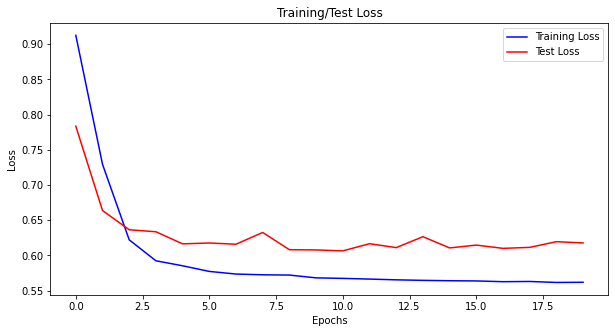

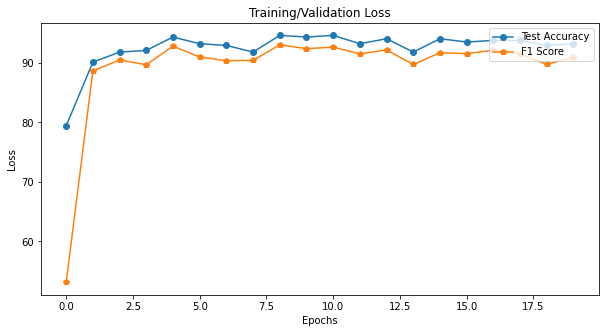

CPU times: user 18min 18s, sys: 2min 6s, total: 20min 25s
Wall time: 20min 29s


In [ ]:
%%time
#Tuning on Validation set

#Rebalancing train and test data to account for selected batch_size
train_size = len(train_x_input)-len(train_x_input)%batch_size # Must be a multiple of the batch size
train_size=int(train_size)
temp = list(range(0,len(train_x_input)))
train_seq = random.sample(temp,train_size) # Must be a multiple of the batch size

[temp.remove(i) for i in train_seq]
val_seq = temp

train_x_input1 = np.array(train_x_input)[train_seq]
train_x_mask1 = np.array(train_x_mask)[train_seq]
train_y1 = np.array(train_y)[train_seq]
val_x_input1 = np.append(np.array(train_x_input)[val_seq], val_x_input, axis=0)
val_x_mask1 = np.append(np.array(train_x_mask)[val_seq], val_x_mask, axis=0)
val_y1 = np.append(np.array(train_y)[val_seq], val_y, axis=0)

#Create Tensor training Dataset and dataloader
train_data=TensorDataset(torch.LongTensor(train_x_input1).to(device), torch.LongTensor(train_x_mask1).to(device), torch.LongTensor(train_y1).to(device))
loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)

#Create a val loader
test_data = TensorDataset(torch.LongTensor(val_x_input1).to(device), torch.LongTensor(val_x_mask1).to(device), torch.LongTensor(val_y1).to(device))
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

#Initializing model
model = NeuralNet()
model = model.to(device)

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Train model for kth CV
train(loss_function, optimizer, model, loader, num_epochs=num_epochs)
    

# Checking results from CV

In [ ]:
classes = ['Negative', 'Neutral', 'Positive']
true1=[classes[np.argmax(i)] for i in true]
pred1=[classes[np.argmax(i)] for i in pred]

In [ ]:
print(metrics.classification_report(true1,pred1))
metrics.confusion_matrix(true1,pred1) #row is "true" and column is "predicted"

              precision    recall  f1-score   support

    Negative       0.88      0.92      0.90        99
     Neutral       0.97      0.95      0.96       220
    Positive       0.89      0.86      0.87        36

    accuracy                           0.93       355
   macro avg       0.91      0.91      0.91       355
weighted avg       0.93      0.93      0.93       355



array([[ 91,   5,   3],
       [ 10, 209,   1],
       [  3,   2,  31]])

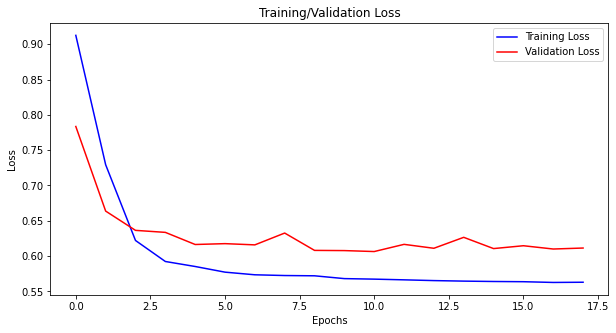

In [ ]:
  history=np.array(history)
  mat.figure(figsize=(10,5))
  mat.plot(history[0:18,0], 'b-', label='Training Loss')
  mat.plot(history[0:18,1], 'r-', label='Validation Loss')
  mat.title("Training/Validation Loss")
  mat.xlabel("Epochs")
  mat.ylabel("Loss")
  mat.legend(loc="upper right") 
  mat.show()

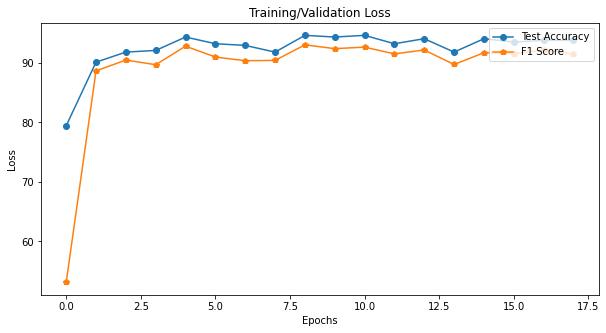

In [ ]:
  mat.figure(figsize=(10,5))
  mat.plot(history[0:18,2], 'o-', label='Test Accuracy')
  mat.plot(history[0:18,3], 'p-', label='F1 Score')
  mat.title("Training/Validation Loss")
  mat.xlabel("Epochs")
  mat.ylabel("Loss")
  mat.legend(loc="upper right") 
  mat.show()

In [ ]:
#Create a test loader for checking training accuracy
test_data = TensorDataset(torch.LongTensor(train_x_input1).to(device), torch.LongTensor(train_x_mask1).to(device), torch.LongTensor(train_y1).to(device))
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
count=0
for test_input, test_mask, labels in test_loader:
  batch_size_model=1
  outputs = model.forward(test_input, test_mask)
  if np.argmax((outputs.detach().tolist())[0])==np.argmax(labels.tolist()[0]):
        count=count+1

print("Accuracy(%):")
print(count/len(train_y1)*100)
print("")

Accuracy(%):
99.0188953488372



# The rest of this if for training the final model for estimating "generalized accuracy"

In [ ]:
#Finalized hyperparameters
batch_size=32
learning_rate=0.00001
num_epochs = 7

#Initializing model
model = NeuralNet()
model = model.to(device)

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Rebalancing train and test data to account for selected batch_size
train_size = len(train_x_input)-len(train_x_input)%batch_size # Must be a multiple of the batch size
train_size=int(train_size)
temp = list(range(0,len(train_x_input)))
train_seq = random.sample(temp,train_size) # Must be a multiple of the batch size

train_x_input2 = np.array(train_x_input)[train_seq]
train_x_mask2 = np.array(train_x_mask)[train_seq]
train_y2 = np.array(train_y)[train_seq]

In [ ]:
#create Tensor Dataset
train_data=TensorDataset(torch.LongTensor(train_x_input2).to(device), torch.LongTensor(train_x_mask2).to(device), torch.LongTensor(train_y2).to(device))

#dataloader
loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
# # Printing loader information
# counter = 0
# for batched_x_input, batched_x_mask, batched_y in loader:
#   print(f"Iteration {counter}")
#   print("Batched Input:")
#   print(batched_x_input)
#   print("Batched Mask:")
#   print(batched_x_mask)
#   print("Batched Labels:")
#   print(batched_y)
#   print("")
#   counter += 1

In [ ]:
# Create a test loader
test_data=TensorDataset(torch.LongTensor(test_x_input).to(device), torch.LongTensor(test_x_mask).to(device), torch.LongTensor(test_y).to(device))
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
# # Printing loader information
# counter = 0
# for batched_x_input, batched_x_mask, batched_y in test_loader:
#   print(f"Iteration {counter}")
#   print("Batched Input:")
#   print(batched_x_input)
#   print("Batched Mask:")
#   print(batched_x_mask)
#   print("Batched Labels:")
#   print(batched_y)
#   print("")
#   counter += 1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-pack

Epoch: 1 Losses: (0.8941451914088673, 0.7631282189677903) Test Accuracy: 78.90173410404624 F1: 52.42862034547825


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-pack

Epoch: 2 Losses: (0.6966723460097647, 0.63398789291437) Test Accuracy: 92.48554913294798 F1: 90.32573577666717


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-pack

Epoch: 3 Losses: (0.6144428592781686, 0.6125195426058906) Test Accuracy: 93.9306358381503 F1: 90.97590426545406


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-pack

Epoch: 4 Losses: (0.5893819754899933, 0.6181041289960718) Test Accuracy: 93.0635838150289 F1: 90.77194573149022


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-pack

Epoch: 5 Losses: (0.5785589141901147, 0.6076912871330453) Test Accuracy: 94.21965317919076 F1: 91.83694050190452


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-pack

Epoch: 6 Losses: (0.5741984345192136, 0.6042973013282515) Test Accuracy: 94.79768786127167 F1: 92.73262854857344


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-pack

Epoch: 7 Losses: (0.5715466536754785, 0.5997496142208228) Test Accuracy: 95.37572254335261 F1: 93.27648112317544


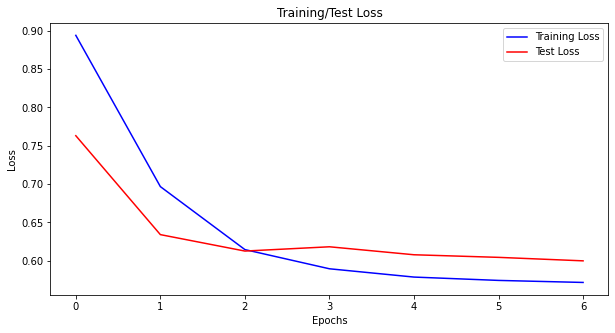

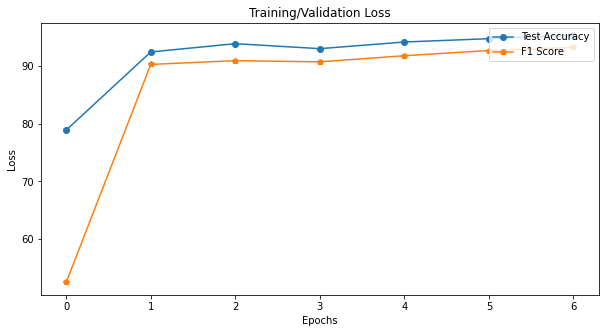

In [ ]:
train(loss_function, optimizer, model, loader, num_epochs=num_epochs)

In [ ]:
# Saving model
torch.save(model.state_dict(), '/content/model_BERT_07')

In [ ]:
# # Loading model (Must run all code before # Define an optimizer)
# model.load_state_dict(torch.load('/Users/sarkaajsingh/Library/CloudStorage/OneDrive-Personal/OneNote/Python Files/SQB7002/model_BERT'))
# model.eval()

In [ ]:
count=0
for test_input, test_mask, labels in test_loader:
  outputs = model.forward(test_input, test_mask)
  print(labels)
  print(outputs)
  if np.argmax((outputs.detach().tolist())[0])==np.argmax(labels.tolist()[0]):
        count=count+1

tensor([[0, 1, 0]], device='cuda:0')
tensor([[2.5733e-04, 9.9955e-01, 1.9080e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0, 1, 0]], device='cuda:0')
tensor([[1.6372e-04, 9.9963e-01, 2.0699e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1, 0, 0]], device='cuda:0')
tensor([[9.9851e-01, 7.3525e-04, 7.5758e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0, 1, 0]], device='cuda:0')
tensor([[1.7662e-04, 9.9959e-01, 2.3024e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1, 0, 0]], device='cuda:0')
tensor([[9.9846e-01, 7.3140e-04, 8.0645e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0, 1, 0]], device='cuda:0')
tensor([[0.0435, 0.9549, 0.0016]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0, 1, 0]], device='cuda:0')
tensor([[2.1969e-04, 9.9950e-01, 2.8418e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1, 0, 0]], device='cuda:0')
tensor([[9.9844e-01, 8.8878e-0

In [ ]:
print("Accuracy(%):")
print(count/len(test_x_input)*100)

Accuracy(%):
95.37572254335261


In [ ]:
np.sum(test_y,axis=0)

array([ 91, 218,  37])

In [ ]:
np.sum(test_y,axis=0)[np.argmax(np.sum(test_y,axis=0))]/np.sum(np.sum(test_y,axis=0))*100

63.005780346820806

# Computing full model for deployment using entire training data

In [ ]:
# Function that will be called in every epoch
def train_epoch(loss_function, optimizer, model, loader):
  
  model.train()
  # Keep track of the total loss for the batch
  total_loss_train = 0
  for batch_inputs, batch_mask, batch_labels in loader:
    # Clear the gradients
    optimizer.zero_grad()
    # Run a forward pass
    global batch_size_model
    batch_size_model=batch_size
    outputs = model.forward(batch_inputs, batch_mask)
    # Compute the batch loss
    loss = loss_function(outputs, batch_labels)
    # Calculate the gradients
    loss.backward()
    #Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1)
    # Update the parameteres
    optimizer.step()
    total_loss_train += loss.item() #one full epoch loss

  model.eval() 
  
  return total_loss_train


# Function containing our main training loop
def train(loss_function, optimizer, model, loader, num_epochs):
  global history
  history=[]
  # Iterate through each epoch and call our train_epoch function
  for epoch in range(num_epochs):
    epoch_loss = train_epoch(loss_function, optimizer, model, loader)
    if epoch % 1 == 0: print('Epoch:',epoch,'Losses:', epoch_loss)
    history.append(epoch_loss)
    
  history=np.array(history)
  mat.figure(figsize=(10,5))
  mat.plot(history, 'b-', label='Training Loss')
  mat.title("Training Loss")
  mat.xlabel("Epochs")
  mat.ylabel("Loss")
  mat.legend(loc="upper right") 
  mat.show()
        

In [ ]:
#Finalized hyperparameters
batch_size=32
learning_rate=0.00001
num_epochs = 7

#Initializing model
model = NeuralNet()
model = model.to(device)

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Rebalancing train and test data to account for selected batch_size
size = len(x_input)-len(x_input)%batch_size # Must be a multiple of the batch size
size=int(size)
temp = list(range(0,len(x_input)))
train_seq = random.sample(temp,size) # Must be a multiple of the batch size

x_input2 = np.array(x_input)[train_seq]
x_mask2 = np.array(x_mask)[train_seq]
y2 = np.array(y)[train_seq]

In [ ]:
print(len(x_input2))
print(len(x_mask2))
print(len(y2))

3424
3424
3424


In [ ]:
#create Tensor Dataset
train_data=TensorDataset(torch.LongTensor(x_input2).to(device), torch.LongTensor(x_mask2).to(device), torch.LongTensor(y2).to(device))

#dataloader
loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
# # Printing loader information
# counter = 0
# for batched_x_input, batched_x_mask, batched_y in test_loader:
#   print(f"Iteration {counter}")
#   print("Batched Input:")
#   print(batched_x_input)
#   print("Batched Mask:")
#   print(batched_x_mask)
#   print("Batched Labels:")
#   print(batched_y)
#   print("")
#   counter += 1

Epoch: 0 Losses: 92.99679720401764
Epoch: 1 Losses: 70.58621513843536
Epoch: 2 Losses: 65.04385358095169
Epoch: 3 Losses: 62.69447183609009
Epoch: 4 Losses: 61.92827308177948
Epoch: 5 Losses: 61.767823696136475
Epoch: 6 Losses: 60.86726152896881


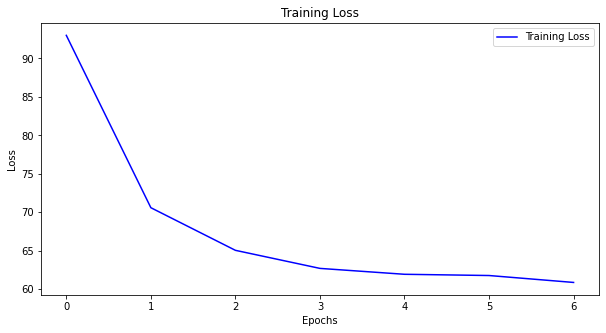

In [ ]:
train(loss_function, optimizer, model, loader, num_epochs=num_epochs)

In [ ]:
#Create a test loader for checking training accuracy
test_data = TensorDataset(torch.LongTensor(x_input2).to(device), torch.LongTensor(x_mask2).to(device), torch.LongTensor(y2).to(device))
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
  pred=[]; true=[] 
  for input, mask, labels in test_loader:
    # Run a forward pass
    batch_size_model=1
    outputs = model.forward(input, mask)
    # For metrics computation
    pred_temp = [0,0,0]
    pred_temp[np.argmax((outputs.detach().tolist())[0])]=1
    pred.append(pred_temp)
    true_temp = labels.tolist()[0]
    true.append(true_temp)
    accuracy = metrics.accuracy_score(true,pred)*100
    f1=metrics.f1_score(true,pred,average="macro")*100

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-pack

In [ ]:
classes = ['Negative', 'Neutral', 'Positive']
true1=[classes[np.argmax(i)] for i in true]
pred1=[classes[np.argmax(i)] for i in pred]

In [ ]:
print('Training Accuracy:', accuracy)
print('F1 Score:', f1)
print(metrics.classification_report(true1,pred1))
metrics.confusion_matrix(true1,pred1) #row is "true" and column is "predicted"

Training Accuracy: 98.39369158878505
F1 Score: 97.88203421752453
              precision    recall  f1-score   support

    Negative       0.98      0.97      0.97       878
     Neutral       0.99      0.99      0.99      2130
    Positive       0.96      0.98      0.97       416

    accuracy                           0.98      3424
   macro avg       0.98      0.98      0.98      3424
weighted avg       0.98      0.98      0.98      3424



array([[ 852,   18,    8],
       [  13, 2108,    9],
       [   5,    2,  409]])

In [ ]:
# Saving model
torch.save(model.state_dict(), '/content/model_BERT_final_07')